In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
session= SparkSession.builder.appName("sparkstreaming").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=76fac49ce82d7efd2ebf83854220f711e7abc5f625f235685e0e3d32795878ae
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
healthdata=session.read.csv("healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)
#Displaying the information of the columns
print("Information of columns:\n",healthdata.columns)

#Displaying the information of number of columns
print("Number of columns:",len(healthdata.columns))

#Displaying Data types of columns
print("Data Types of all columns:",healthdata.dtypes)

#Displaying the number of records using count() action
print("Total Number of records:",healthdata.count())

#Displaying statistics of all columns
print("Information of dataset:\n",healthdata.describe().show())

#Displaying statistics of selected columns
print("Information:",healthdata.describe('avg_glucose_level','bmi').show())

Information of columns:
 ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Number of columns: 12
Data Types of all columns: [('id', 'int'), ('gender', 'string'), ('age', 'double'), ('hypertension', 'int'), ('heart_disease', 'int'), ('ever_married', 'string'), ('work_type', 'string'), ('Residence_type', 'string'), ('avg_glucose_level', 'double'), ('bmi', 'string'), ('smoking_status', 'string'), ('stroke', 'int')]
Total Number of records: 5110
+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+--

In [ ]:
from pyspark.sql.functions import col
healthdata = healthdata.withColumn("bmi", col("bmi").cast("float"))
healthdata = healthdata.withColumn("avg_glucose_level", col("avg_glucose_level").cast("float"))
print("Data Types of all columns:",healthdata.dtypes)

Data Types of all columns: [('id', 'int'), ('gender', 'string'), ('age', 'double'), ('hypertension', 'int'), ('heart_disease', 'int'), ('ever_married', 'string'), ('work_type', 'string'), ('Residence_type', 'string'), ('avg_glucose_level', 'float'), ('bmi', 'float'), ('smoking_status', 'string'), ('stroke', 'int')]


In [ ]:
healthdata_cleaned = healthdata.dropna(subset=['bmi'])

# Check the count of rows after removing N/A values
final_count = healthdata_cleaned.count()
final_count

4909

In [ ]:
#Adding a new column based on the user defined function
from pyspark.sql.functions import udf
from pyspark.sql.types import *

#Creating a function
def bmi_function(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi >= 18.5 and bmi < 25.0:
        return 'Normal'
    elif bmi >= 25.0 and bmi < 30.0:
        return 'Overweight'
    else:
        return 'Obese'

def glucose_level_function(glucose_level):
    if glucose_level < 100.0:
        return 'Normal'
    elif glucose_level >= 100.0 and glucose_level < 140.0:
        return 'Pre-diabetic'
    else:
        return 'Diabetic'

#Creating a user defined function
bmi_udf=udf(bmi_function,StringType())
glucose_udf=udf(glucose_level_function,StringType())

#Adding a new column containing value based on user defined function
result = healthdata_cleaned.withColumn('BMI_indication', bmi_udf(healthdata_cleaned['bmi'])).withColumn('glucose_level_indication', glucose_udf(healthdata_cleaned['avg_glucose_level']))

#Displaying the results
result.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+------------------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|BMI_indication|glucose_level_indication|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+--------------+------------------------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|         Obese|                Diabetic|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|         Obese|            Pre-diabetic|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smoke

 1. investigate the prevalence of stroke across different BMI categories and glucose level indications. This can help identify which groups are at higher risk and therefore might benefit most from targeted health interventions.


In [ ]:
from pyspark.sql import functions as F
insight1 = result.groupBy("BMI_indication", "glucose_level_indication") \
    .agg(
        F.count("*").alias("total_individuals"),
        F.sum(F.when(F.col("stroke") == 1, 1).otherwise(0)).alias("stroke_cases"),
        F.round((F.sum(F.when(F.col("stroke") == 1, 1).otherwise(0)) / F.count("*")) * 100, 2).alias("stroke_percentage")
    ) \
    .orderBy(F.col("stroke_percentage").desc()).collect()


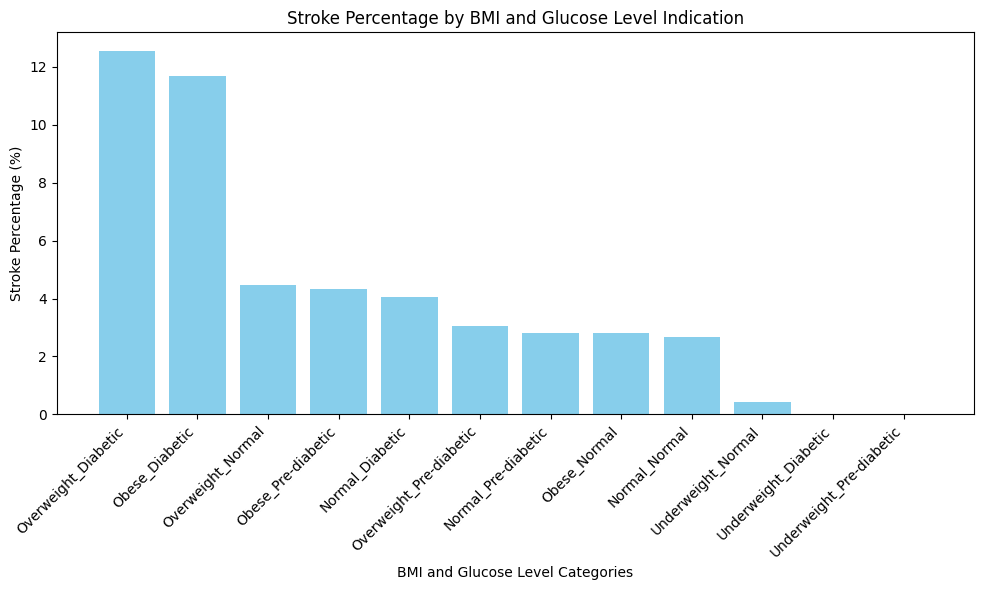

In [ ]:
import matplotlib.pyplot as plt

categories = [f"{x['BMI_indication']}_{x['glucose_level_indication']}" for x in insight1]
stroke_percentages = [x['stroke_percentage'] for x in insight1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, stroke_percentages, color='skyblue')
plt.xlabel('BMI and Glucose Level Categories')
plt.ylabel('Stroke Percentage (%)')
plt.title('Stroke Percentage by BMI and Glucose Level Indication')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

High Risk in Overweight and Diabetic Individuals: The highest stroke percentages are observed in individuals who are either Overweight and Diabetic (12.56%) or Obese and Diabetic (11.68%). This highlights a significant correlation between diabetes, excess weight, and stroke risk.

Solution: Targeted interventions for individuals with diabetes and those who are overweight or obese could significantly reduce stroke risk. These interventions might include diabetes management programs, weight loss programs, and lifestyle modification support such as diet and exercise counseling.

2. How different lifestyle factors and demographics correlate with stroke risk, helping identify high-risk groups for targeted preventive measures and health interventions.

In [ ]:
age_buckets = F.when(F.col("age") < 18, "Under 18") \
               .when((F.col("age") >= 18) & (F.col("age") <= 30), "18-30") \
               .when((F.col("age") > 30) & (F.col("age") <= 45), "31-45") \
               .when((F.col("age") > 45) & (F.col("age") <= 60), "46-60") \
               .otherwise("Above 60")

stroke_analysis = result.withColumn("age_group", age_buckets) \
    .groupBy("gender", "age_group", "work_type", "Residence_type") \
    .agg(
        F.count("*").alias("total_individuals"),
        F.sum(F.when(F.col("stroke") == 1, 1).otherwise(0)).alias("stroke_cases"),
        F.round((F.sum(F.when(F.col("stroke") == 1, 1).otherwise(0)) / F.count("*")) * 100, 2).alias("stroke_percentage")
    ) \
    .orderBy("stroke_percentage", ascending=False).show()

+------+---------+-------------+--------------+-----------------+------------+-----------------+
|gender|age_group|    work_type|Residence_type|total_individuals|stroke_cases|stroke_percentage|
+------+---------+-------------+--------------+-----------------+------------+-----------------+
|  Male| Above 60|      Private|         Urban|              141|          21|            14.89|
|  Male| Above 60|      Private|         Rural|              136|          20|            14.71|
|Female| Above 60|     Govt_job|         Rural|               46|           6|            13.04|
|Female| Above 60|      Private|         Rural|              174|          22|            12.64|
|  Male| Above 60|Self-employed|         Urban|               82|          10|             12.2|
|Female| Above 60|      Private|         Urban|              177|          21|            11.86|
|Female| Above 60|     Govt_job|         Urban|               60|           7|            11.67|
|Female| Above 60|Self-employe

- Age and Gender Impact: The highest stroke percentages are found in individuals above 60 years of age, with males in the Private sector (both Urban and Rural) having the highest incidence of stroke at 14.89% and 14.71%, respectively. This suggests that age is a significant risk factor for stroke, with older males in the workforce, particularly in the Private sector, being at higher risk.
- Rural vs. Urban Residence: The difference between rural and urban settings in stroke cases is minimal, suggesting that the location of residence (rural or urban) has less impact on stroke risk compared to age, gender, and work type. However, there's a slight trend that indicates individuals living in urban areas might be at a marginally higher risk, possibly due to lifestyle factors associated with urban living.
- Younger Age Groups: While the focus is predominantly on individuals above 60, the data also shows stroke cases in the 46-60 and 31-45 age groups. Although the percentages are lower, it highlights that middle-aged individuals are not immune to stroke risk. Especially, males aged 31-45 who are self-employed and live in urban areas, and both genders working in private and government sectors in the 46-60 age group, show noticeable stroke percentages.

## Data Analysis of the Network of Doctors and Patients using Graphframe

In [ ]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

from graphframes import *
from graphframes import GraphFrame
from pyspark import *
from pyspark.sql import *
spark = SparkSession.builder.appName('pyspark').getOrCreate()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read the CSV files
doctors_df = pd.read_csv('Doctors1.csv')
patients_df = pd.read_csv('Patients.csv')

doctors_df.rename(columns={'Doctor_ID': 'id'}, inplace=True)

patients_df.rename(columns={'Patient_ID': 'id'}, inplace=True)

result_df = pd.concat([doctors_df, patients_df], ignore_index=True)

result_df['Classification'] = result_df['id'].apply(lambda x: 'Doctor' if len(str(x)) <= 2 else 'Patient')

# Save the final dataframe to a new CSV file
result_df.to_csv('Vertices.csv', index=False)


In [ ]:
!pip install graphframes

3. What can the healthcare network reveal about the patterns of connectivity among doctors and patients? This analysis will thereby help identify key healthcare providers and optimize patient care pathways for improved healthcare outcomes.

In [ ]:
vertices = session.read.option('header', 'true').csv('Vertices.csv')
edges = session.read.option('header', 'true').csv('Edges.csv')

mygraph = GraphFrame(vertices, edges)


def plot_undirected_graph(edge_list):
    plt.figure(figsize=(20,20))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=600)
plot_undirected_graph(mygraph.edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling o193.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


Here, we utilize data from two separate files containing details of doctors and patients, respectively, alongside a third file capturing the relational data between doctors and patients. Through careful processing of this data, we construct two essential files: Vertices and Edges. These files serve as the backbone for creating a graphframe, a powerful tool enabling us to analyze network relationships between doctors and patients. By harnessing the capabilities of the graphframe, we can gain valuable insights into the intricate connections within our healthcare ecosystem. For instance, we can ascertain which patients are associated with specific doctors, unveiling patterns that may inform medical resource allocation, patient care strategies, and healthcare policy decisions. Through our analysis of this graph frame, we aim to uncover meaningful relationships and patterns that can drive informed decision-making and enhance the quality of healthcare delivery.

In [ ]:
# Performing triangle count and showing the result in descending order
triangle_counts = mygraph.triangleCount()
triangle_counts.orderBy('count', ascending=False).show()

In our analysis, we delve deeper into the network dynamics by constructing a table showcasing triangle counts within the network. This crucial step offers profound insights into the connectivity patterns among doctors and patients, shedding light on nodes that are central to the network.
1. By examining triangle counts, we can discern which doctors have the highest number of patient connections, highlighting key healthcare providers who play pivotal roles in patient care.
2. Moreover, beyond identifying doctors with the highest and lowest patient counts, triangle counts enable us to uncover additional insights. For instance, we can identify clusters of doctors and patients who are interconnected, potentially indicating specialized medical practices or referral networks.

By leveraging these insights, healthcare organizations can optimize patient care pathways, enhance collaboration among medical professionals, and ultimately improve healthcare outcomes for patients.

In [ ]:
tcounts_df = triangle_counts.orderBy('count', ascending=False).toPandas()

edges_pd = edges.toPandas()
merge1 = pd.merge(tcounts_df, edges_pd, left_on='id', right_on='src', how='inner')
merge1['dst'] = merge1['dst'].astype(str)
patients_df['id'] = patients_df['id'].astype(str)
merge2 = pd.merge(merge1, patients_df, left_on='dst', right_on='id', how='inner')
merge2 = merge2.sort_values(by='count', ascending=False)
merge2[['count', 'id_x', 'First_Name_x', 'Last_Name_x', 'Years_of_Experience', 'Hospital_Name', 'Disease_y']].head(9)

Following the acquisition of triangle counts data, we embarked on a deeper exploration by augmenting the dataset with disease information. This strategic enhancement facilitates a comprehensive understanding of the network dynamics, offering valuable insights into the intersection of doctor connectivity and prevalent medical conditions. By correlating doctor connectivity with the diseases they are treating, we unlock a wealth of insights.
1. For instance, we can identify doctors with the highest connectivity in the network and discern the predominant diseases they manage, providing valuable intelligence for healthcare resource allocation and specialization identification.  
2. Additionally, we can assess the impact of doctor-patient connectivity on disease management outcomes, informing targeted interventions and care coordination strategies.

Through meticulous analysis of triangle counts data in conjunction with disease information, our endeavor aims to empower healthcare stakeholders with actionable insights for optimizing patient care pathways, enhancing clinical decision-making. Similar analysis can be performed using triangle counts with any other relevant information for any other business needs that a healthcare company might have.

### Implementing Spark Streaming Simulation to Show the Analysis of the Temporal data

In [ ]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("sparkstreaming").getOrCreate()


In [ ]:
import shutil
src=r"healthcare-dataset-stroke-data.csv"
dest = r"HealthDir2"
shutil.copy(src,dest)

#Reading the data
health_data2=session.read.csv('healthcare-dataset-stroke-data.csv', header=True, inferSchema=True)

#Reading the stream of data by specifying the schema and directory
healthdata_stream2=session.readStream.schema(health_data2.schema).csv('HealthDir2/')

#Writing the stream of data to a table named emptable
#The output mode is append which means that the data will be added always to existing table
health_query2=healthdata_stream2.writeStream.queryName("patient_table2").format("memory").outputMode("append").start()






### Simulating the streaming data of residence type and the frequency of heart strokes in those residence type

In [ ]:

#Copy the EmployeeAttrition.csv file to the Attrition folder
import shutil
src=r"healthcare-dataset-stroke-data.csv"
dest = r"HealthDir2"
shutil.copy(src,dest)

session.sql("select Residence_type,sum(stroke) from patient_table2 group by Residence_type").show()



+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        135|
|Residence_type|       NULL|
|         Rural|        114|
+--------------+-----------+



In [ ]:
session.sql("select Residence_type,sum(stroke) from patient_table2 group by Residence_type").show()


import time
for i in range (6):
    session.sql("select Residence_type,sum(stroke) from patient_table2 group by Residence_type").show()
    newfile="HealthDir2/Emp" + str(i) +  ".csv"
    shutil.copy(src,newfile)
    time.sleep(5)

health_query2.stop()

+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        135|
|Residence_type|       NULL|
|         Rural|        114|
+--------------+-----------+

+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        135|
|Residence_type|       NULL|
|         Rural|        114|
+--------------+-----------+

+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        270|
|Residence_type|       NULL|
|         Rural|        228|
+--------------+-----------+

+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        405|
|Residence_type|       NULL|
|         Rural|        342|
+--------------+-----------+

+--------------+-----------+
|Residence_type|sum(stroke)|
+--------------+-----------+
|         Urban|        540|
|Residence_type|       NULL|
|         Rural|        456|
+---------

### Simulating the streaming data of gender and marital status  and the frequency of heart strokes

In [ ]:

#Reading the data
health_data3=session.read.csv('healthcare-dataset-stroke-data.csv', header=True, inferSchema=True)

#Reading the stream of data by specifying the schema and directory
healthdata_stream3=session.readStream.schema(health_data3.schema).csv('HealthDir3/')

#Writing the stream of data to a table named emptable
#The output mode is append which means that the data will be added always to existing table
health_query3=healthdata_stream3.writeStream.queryName("patient_table3").format("memory").outputMode("append").start()

#Copy the EmployeeAttrition.csv file to the Attrition folder
import shutil
src=r"healthcare-dataset-stroke-data.csv"
dest = r"HealthDir3"
shutil.copy(src,dest)


#session.sql("select gender,ever_married,sum(stroke) from patient_table3 group by gender,ever_married order by gender").show()


'HealthDir3/healthcare-dataset-stroke-data.csv'

In [ ]:
import time
for i in range (6):
    session.sql("select gender,ever_married,sum(stroke) from patient_table3 group by gender,ever_married order by gender").show()
    newfile="HealthDir3/Emp" + str(i) +  ".csv"
    shutil.copy(src,newfile)
    time.sleep(5)


+------+------------+-----------+
|gender|ever_married|sum(stroke)|
+------+------------+-----------+
|Female|          No|         21|
|Female|         Yes|        120|
|  Male|          No|          8|
|  Male|         Yes|        100|
| Other|          No|          0|
|gender|ever_married|       NULL|
+------+------------+-----------+

+------+------------+-----------+
|gender|ever_married|sum(stroke)|
+------+------------+-----------+
|Female|          No|         42|
|Female|         Yes|        240|
|  Male|          No|         16|
|  Male|         Yes|        200|
| Other|          No|          0|
|gender|ever_married|       NULL|
+------+------------+-----------+

+------+------------+-----------+
|gender|ever_married|sum(stroke)|
+------+------------+-----------+
|Female|          No|         63|
|Female|         Yes|        360|
|  Male|          No|         24|
|  Male|         Yes|        300|
| Other|          No|          0|
|gender|ever_married|       NULL|
+------+----

In [ ]:
health_query3.stop()

### Using Machine Learning to predict the Heart Stroke from the health parameters, demographics, lifestyle, and work type of a patient

In [ ]:
from pyspark.sql import SparkSession
session=SparkSession.builder.appName("reg").master("local").getOrCreate()
healthcare_data=session.read.csv("healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)


In [ ]:
healthcare_data.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import round

healthcare_data = healthcare_data.withColumn("bmi", healthcare_data["bmi"].cast("double"))

imputer = Imputer(strategy="mean", inputCols=["bmi"], outputCols=["bmi_imputed"])

model = imputer.fit(healthcare_data)

healthcare_data_filt = model.transform(healthcare_data)

healthcare_data_filt_rounded = healthcare_data_filt.withColumn("bmi_imputed", round(healthcare_data_filt["bmi_imputed"], 1))

filtered_healthcare_data=healthcare_data_filt_rounded.drop("bmi")

filtered_healthcare_data = filtered_healthcare_data.withColumn("age", filtered_healthcare_data["age"].cast("int"))

# Reordering the columns to keep 'bmi_imputed' where 'bmi' was
filtered_healthcare_data = filtered_healthcare_data.select(
    "id", "gender", "age", "hypertension", "heart_disease", "ever_married", "work_type",
    "Residence_type", "avg_glucose_level", "bmi_imputed","smoking_status", "stroke"
)

filtered_healthcare_data.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|       36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21|       28.9|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|       32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|       34.4|         smokes|     1|
| 1665|Female

In [ ]:

#String indexing for categorical columns
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["gender","ever_married","work_type","Residence_type","smoking_status"],outputCols=["indexed_gender","indexed_ever_married","indexed_work_type","indexed_Residence_type","indexed_smoking_status"])



In [ ]:
#One hot encoding
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["indexed_gender","indexed_ever_married","indexed_work_type","indexed_Residence_type","indexed_smoking_status"],outputCols=["new_gender","new_ever_married","new_work_type","new_Residence_type","new_smoking_status"])
#Vector Assembler
from pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["new_gender", "age", "hypertension", "heart_disease", "new_ever_married", "new_work_type", "new_Residence_type", "avg_glucose_level","bmi_imputed", "new_smoking_status"],outputCol="all_features")

In [ ]:
#Splitting the dataset in training and test
training, test=filtered_healthcare_data.randomSplit([0.75,0.25],seed=200)

training.show(2)

test.show(2)

#defining  the accuracy  function which will take the model and name of the model as input and return accuracy

def calculate_accuracy(lrresults,model):
  lrresults=lrresults.withColumn("compare",lrresults['stroke']-lrresults['prediction'])
  correct=lrresults.filter(lrresults['compare']==0).count()
  incorrect=lrresults.filter(lrresults['compare']!=0).count()
  print("The accuracy for  the ",model," model is ",correct/(correct+incorrect))


+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+---------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+---------------+------+
| 67|Female| 17|           0|            0|          No|  Private|         Urban|            92.97|       28.9|formerly smoked|     0|
| 84|  Male| 55|           0|            0|         Yes|  Private|         Urban|            89.17|       31.5|   never smoked|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+---------------+------+
only showing top 2 rows

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+--------------+------+
| id|gender|age|hypertension|he

In [ ]:
#Creating an Object of  Linear Regression
from pyspark.ml.classification import LogisticRegression

#Creating the pipeline
from pyspark.ml import Pipeline


lr=LogisticRegression(featuresCol="all_features", labelCol="stroke")


lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,lr])
#Training the model
lrmodel=lrpipeline.fit(training)

#Predicting the results on test dataset
lrresults=lrmodel.transform(test)

#Displaying the results
lrresults.show(2, truncate=False)

calculate_accuracy(lrresults,"Logistic regression")

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+--------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+-----------------------------------------------------------+--------------------------------------+-----------------------------------------+----------+
|id |gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi_imputed|smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|new_gender   |new_ever_married|new_work_type|new_Residence_type|new_smoking_status|all_features                                               |rawPrediction                         |probability                              |prediction|
+---+------+---+------------+-------------+------------+------

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

forest=RandomForestClassifier(featuresCol='all_features', labelCol="stroke")

forest_pipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,forest])

forest_model=forest_pipeline.fit(training)

forest_results=forest_model.transform(test)

forest_results.show(2, truncate=False)


calculate_accuracy(forest_results,"Random forest Classifier")

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+--------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+-----------------------------------------------------------+---------------------------------------+-----------------------------------------+----------+
|id |gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi_imputed|smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|new_gender   |new_ever_married|new_work_type|new_Residence_type|new_smoking_status|all_features                                               |rawPrediction                          |probability                              |prediction|
+---+------+---+------------+-------------+------------+----

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="stroke")

decisiontreepipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree])

treemodel=decisiontreepipeline.fit(training)

treeresults=treemodel.transform(test)

treeresults.show(2, truncate=False)

calculate_accuracy(forest_results,"Decision Tree Classifier")

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+--------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+-----------------------------------------------------------+-------------+----------------------------------------+----------+
|id |gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi_imputed|smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|new_gender   |new_ever_married|new_work_type|new_Residence_type|new_smoking_status|all_features                                               |rawPrediction|probability                             |prediction|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+-----------+---

### Generating random records and predicting whether the patient can get a stroke or not


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import random
from builtins import round


def generate_medical_records(num_records=10):
    records = []
    genders = ['Male', 'Female']
    ever_married_options = ['Yes', 'No']
    work_types = ['Never_worked', 'Self-employed', 'Private', 'children', 'Govt_job']
    residence_types = ['Urban', 'Rural']
    smoking_statuses = ['formerly smoked', 'never smoked', 'smokes', 'Unknown']

    for i in range(num_records):
        record = {}
        record['id'] = random.randint(10000, 99999)
        record['gender'] = random.choice(genders)
        record['age'] = random.randint(20, 90)
        record['hypertension'] = random.randint(0, 1)
        record['heart_disease'] = random.randint(0, 1)
        record['ever_married'] = random.choice(ever_married_options)
        record['work_type'] = random.choice(work_types)
        record['Residence_type'] = random.choice(residence_types)
        record['avg_glucose_level'] = round(random.uniform(50, 250),2)
        record['bmi_imputed'] = round(random.uniform(10, 50),1)
        record['smoking_status'] = random.choice(smoking_statuses)

        records.append(record)

    return records



#Defining the schema of the data frame
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("hypertension", IntegerType(), True),
    StructField("heart_disease", IntegerType(), True),
    StructField("ever_married", StringType(), True),
    StructField("work_type", StringType(), True),
    StructField("Residence_type", StringType(), True),
    StructField("avg_glucose_level", FloatType(), True),
    StructField("bmi_imputed", FloatType(), True),
    StructField("smoking_status", StringType(), True)

])

#Generate 10 medical records and write the data along with the prediction to a folder.

for i in range(0,2):
  random_records=generate_medical_records()
  records_df = session.createDataFrame(random_records, schema)
  lrresults = lrmodel.transform(records_df)


  # Join the DataFrames on the ID column
  joined_df = records_df.join(lrresults.select("id", "prediction"), on="id", how="inner")
  joined_df = joined_df.withColumnRenamed("prediction", "stroke").withColumn("stroke", col("stroke").cast("int"))
  joined_df.show()
  # Define the output file path
  output_filr = "InputDir/"
  joined_df.write.mode("append").option("header", "true").csv(output_filr)




+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
|15224|Female| 47|           0|            0|          No|     Govt_job|         Rural|           106.33|       29.8|formerly smoked|     0|
|17049|  Male| 44|           1|            1|          No|     Govt_job|         Urban|            69.07|       12.5|        Unknown|     0|
|50897|Female| 39|           1|            1|          No|     Govt_job|         Rural|           235.81|       24.5|formerly smoked|     0|
|60188|  Male| 77|           1|            0|         Yes|      Private|         Urban|           142.81|       30.1|        Unknown|     0|
|62821|Female

### Unsupervised Learning - Identifying clusters/groups of similar data using Kmeans Clustering


In [ ]:
#Importing the necessary libraries for unsupervised learning using kmeans

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


In [ ]:

data_pipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj])

data_fitted=data_pipeline.fit(filtered_healthcare_data)

newdata=data_fitted.transform(filtered_healthcare_data)
newdata.show(2)



+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+--------------------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|   new_gender|new_ever_married|new_work_type|new_Residence_type|new_smoking_status|        all_features|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------

In [ ]:
kmeans=KMeans(featuresCol="all_features").setK(3)
results=kmeans.fit(newdata).transform(newdata)
results.show(10)




+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+--------------------+----------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|   new_gender|new_ever_married|new_work_type|new_Residence_type|new_smoking_status|        all_features|prediction|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+---

In [ ]:
from pyspark.sql.functions import col


for cluster_id in range(4):
    cluster_data = results.filter(col("prediction") == cluster_id)
    print(f"Cluster {cluster_id}:")
    cluster_data.show(10)


Cluster 0:
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+--------------------+----------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|   new_gender|new_ever_married|new_work_type|new_Residence_type|new_smoking_status|        all_features|prediction|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

results.filter(col("prediction") == 1).show()

print(results.columns)

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+------------------+------------------+--------------------+----------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi_imputed| smoking_status|stroke|indexed_gender|indexed_ever_married|indexed_work_type|indexed_Residence_type|indexed_smoking_status|   new_gender|new_ever_married|new_work_type|new_Residence_type|new_smoking_status|        all_features|prediction|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+----------------+-------------+---

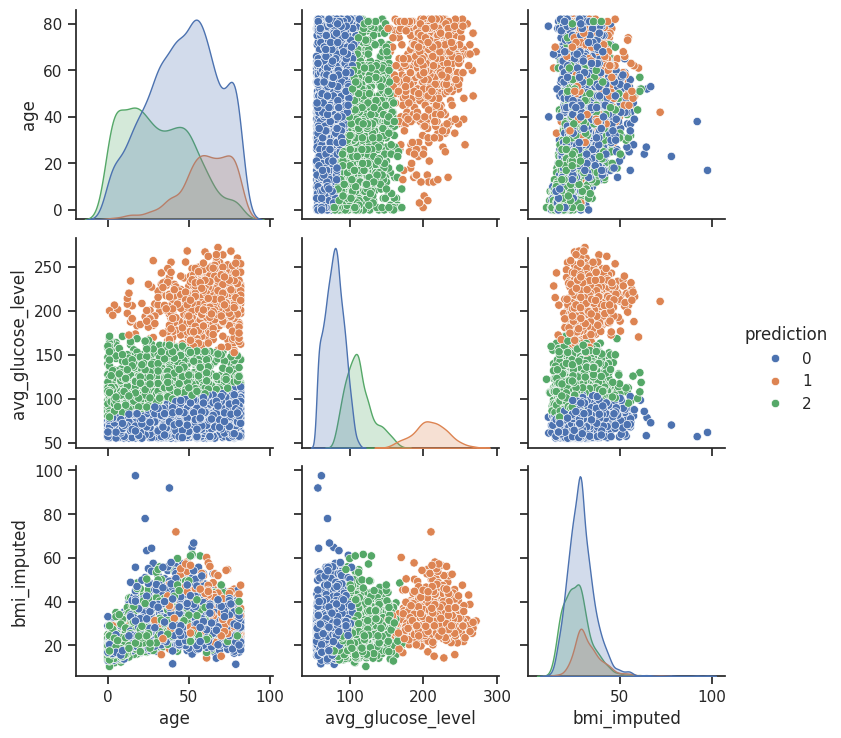

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extract features and cluster predictions

features = ['age', 'avg_glucose_level', 'bmi_imputed']

cluster_column = 'prediction'
data_to_plot = results.select(features + [cluster_column])

# Set the style of seaborn
sns.set(style="ticks")

# Plot scatterplot for each pair of features
sns.pairplot(data_to_plot.toPandas(), hue="prediction", palette="deep")
plt.show()

 We delved into the dataset's potential patterns and correlations using k-means clustering with a set number of clusters, k, equal to 3. Our goal was to identify distinct groupings or clusters of individuals based on their demographic and health-related attributes. Despite our comprehensive analysis and utilization of k-means clustering, our findings revealed limited discernible patterns within the dataset. However, we did manage to uncover a subtle correlation between body mass index (BMI) and average glucose level among certain clusters, indicating a potential association between these variables. Nonetheless, the overall dataset did not provide significant insights or clear distinctions that could be effectively captured through k-means clustering alone. This highlights the complexity and diversity of factors contributing to heart stroke risk, emphasizing the necessity for further investigation and refinement of clustering methodologies in subsequent studies. With improved data quality and depth, our model could yield more robust and accurate predictions, paving the way for enhanced understanding and prevention of heart strokes.

**Conclusion**

This research on stroke analysis, leveraging PySpark tools such as Spark SQL, Spark Streaming, GraphFrames, and machine learning, has provided significant insights into stroke risk and healthcare network dynamics. We identified critical factors affecting stroke risk and utilized predictive models to foresee stroke likelihood, enabling early preventive measures. GraphFrames revealed key nodes within healthcare networks, enhancing patient care pathways. Real-time data processing underscored the importance of timely data analysis in healthcare settings. Ultimately, this study not only enriches our understanding of stroke risks but also showcases the transformative potential of big data analytics in healthcare, offering pathways to more proactive, data-driven, and personalized patient care.